In [75]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import joblib


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from imblearn.over_sampling import SMOTE

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

from fedot.api.main import Fedot

import mlflow
from mlflow.models import infer_signature

In [2]:
df = pd.read_csv('/home/gadzhiev.vazhid/study/platf/task2/mod2_practice_data.csv')
df.head()

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77


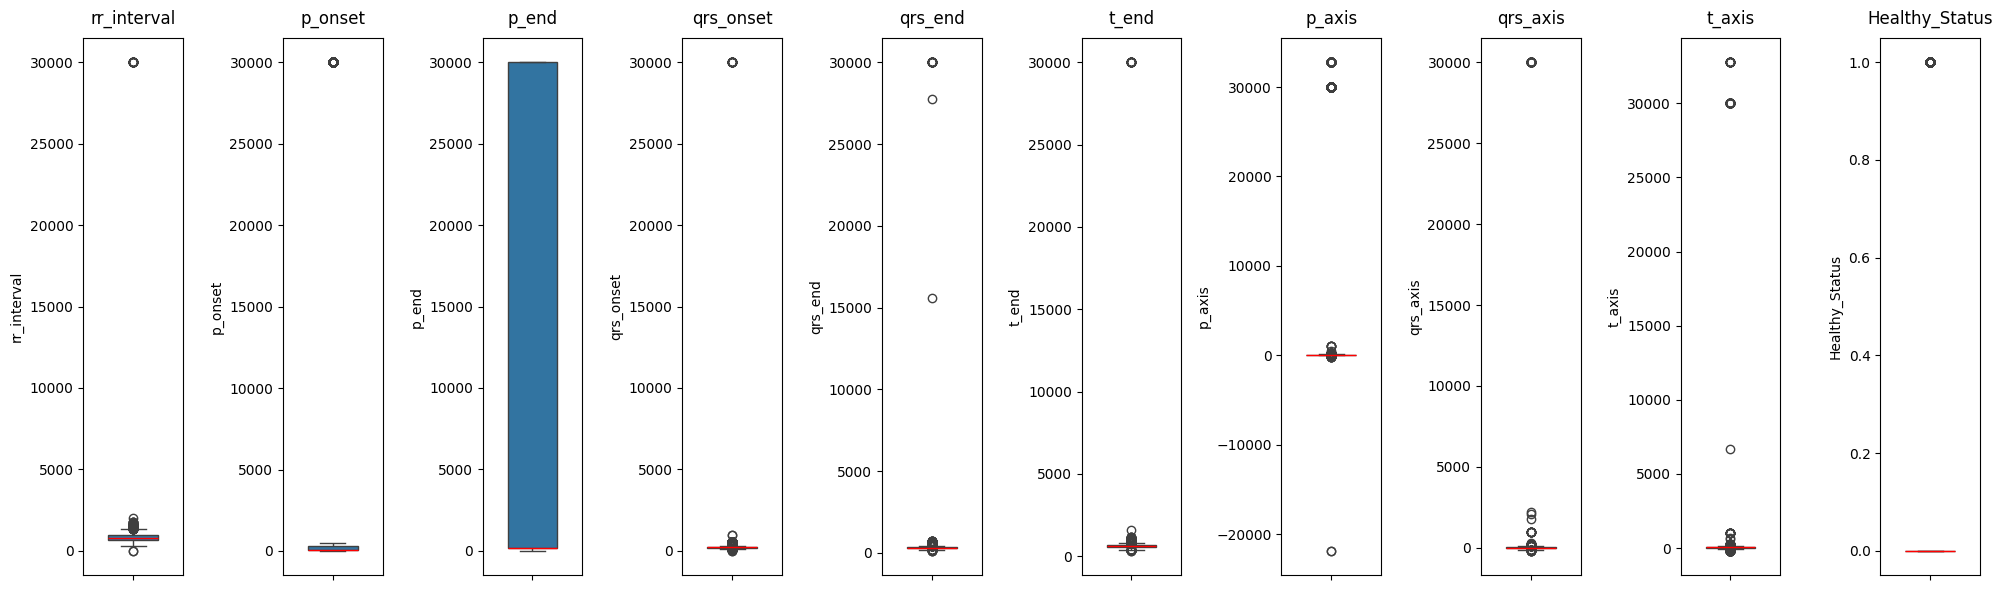

In [11]:
columns_to_filter = [
    'rr_interval','p_onset','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status'
]
full_df_filtered = df[columns_to_filter]

n = full_df_filtered.shape[1]

fig, ax = plt.subplots(1, n, figsize=(n*2, 6))

plt.subplots_adjust(wspace=0.8)

for i in range(n):
    plt.sca(ax[i])
    sns.boxplot(y=full_df_filtered.iloc[:, i], 
                data=full_df_filtered, 
                width=0.5,
                medianprops={"color": "red", "linewidth": 1})
    
    ax[i].set_title(columns_to_filter[i], pad=10)
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Предобрабатываем данные

In [ ]:
# Убираем выбросы
columns_to_filter = [
    'rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis'
]
full_df_filtered = df[(df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[
    (full_df_filtered['p_onset'] < full_df_filtered['p_end']) & 
    (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])
]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = (
    full_df_filtered['report_0'].
    str.replace(r'\bnan\b', '', regex=True).
    str.replace(r'\s+', ' ', regex=True).str.strip()
)
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Исправляем имена столбцов
full_df_filtered = full_df_filtered\
    .rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})\
    .drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered =\
    full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

In [25]:
table_data = full_df_filtered[
    ['rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']
]
table_data.head()

,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,659,128,170,258,518,81,77,79,0
1,722,124,162,246,504,77,75,70,0
2,600,130,162,244,474,79,72,77,1
3,659,146,180,254,538,79,66,69,1
6,952,146,198,282,598,24,80,20,1


### Визиализируем данные с помощью boxplot

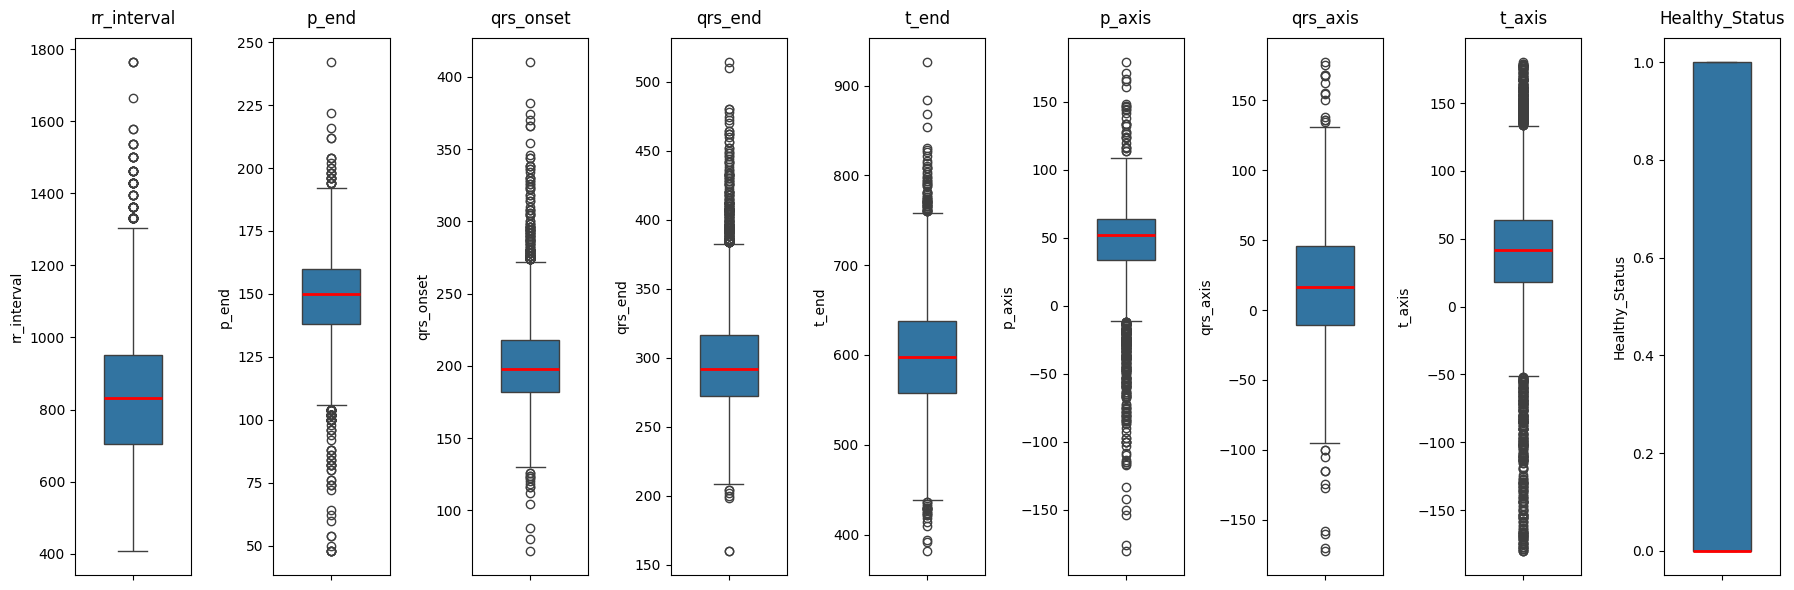

In [26]:
n = table_data.shape[1]
columns_to_filter = table_data.columns  

fig, ax = plt.subplots(1, n, figsize=(n*2, 6))

plt.subplots_adjust(wspace=0.8)

for i in range(n):
    plt.sca(ax[i])
    sns.boxplot(y=table_data.iloc[:, i], 
                data=table_data, 
                width=0.5,
                medianprops={"color": "red", "linewidth": 2})
    
    ax[i].set_title(columns_to_filter[i], pad=10)
    ax[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Визуализируем данные с помощью heatmap

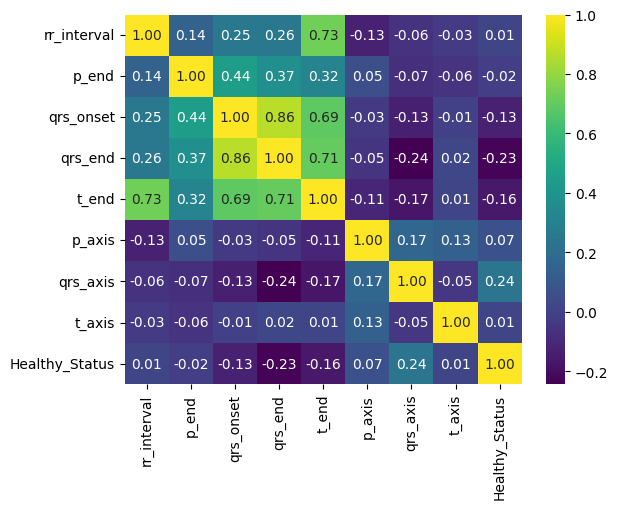

In [29]:
sns.heatmap(table_data.corr(), annot=True, fmt='0.2f', cmap='viridis')
plt.show()

### Визуализируем данные с помощью pairplot

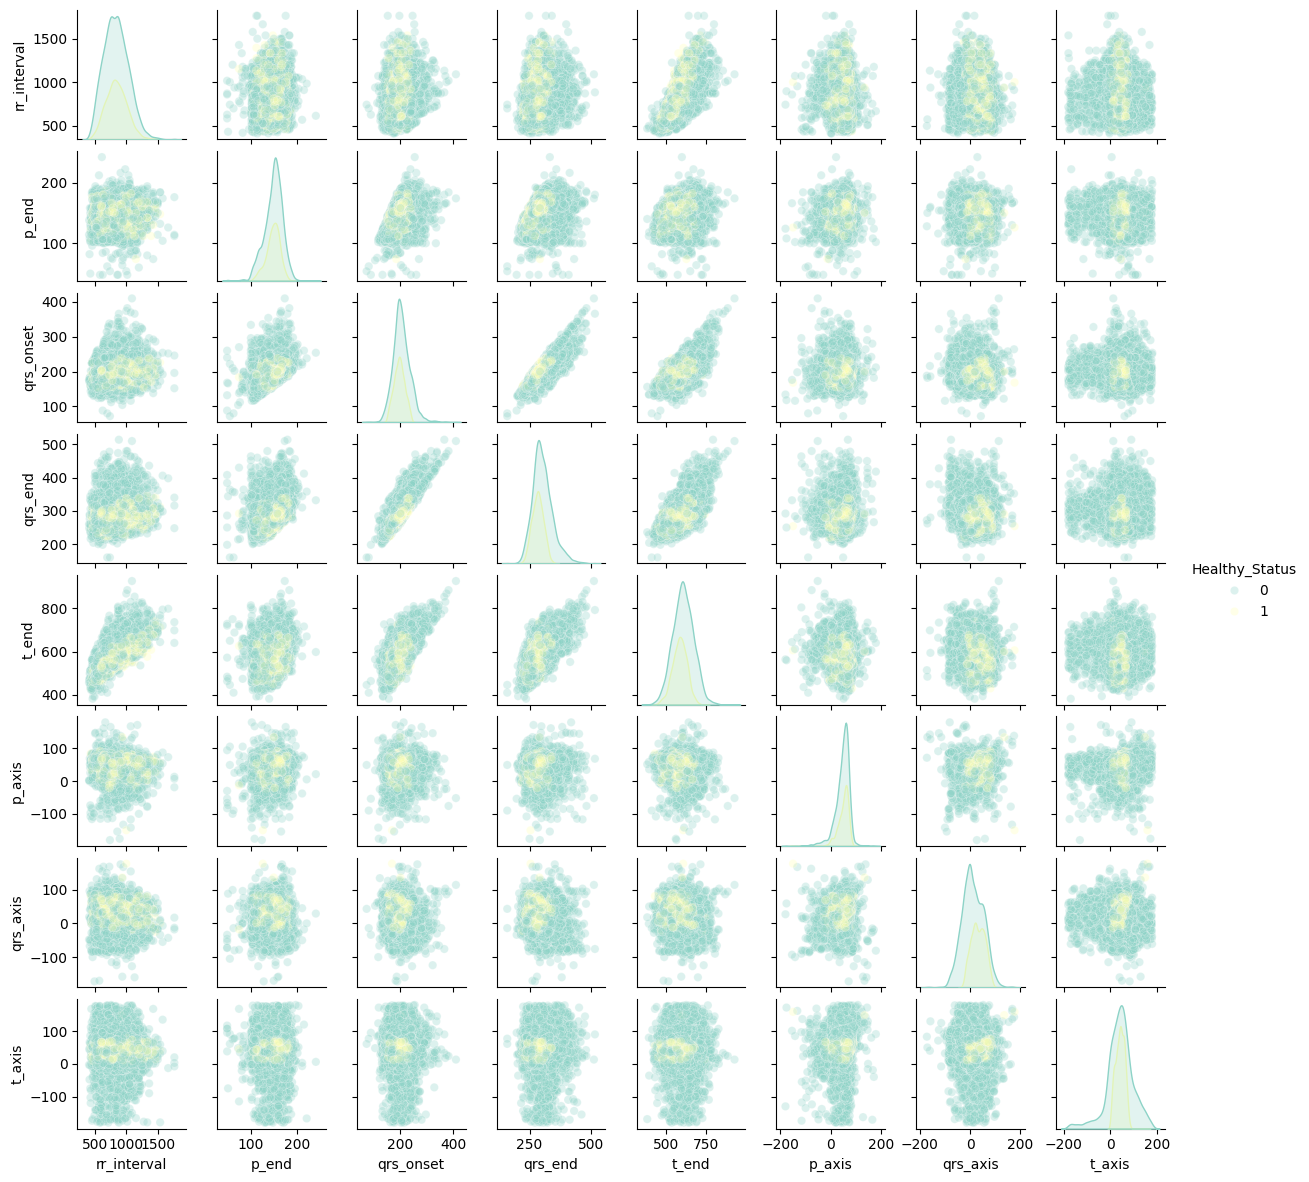

In [34]:
sns.pairplot(table_data, 
             hue='Healthy_Status', 
             height=1.5, 
             plot_kws=dict(alpha=0.3),
             palette='Set3')
plt.show()

### Обработка данных с помощью PCA и t-SNE

In [35]:
table_data_pca = table_data.drop('Healthy_Status', axis = 1)
scaled_data = StandardScaler().fit_transform(table_data_pca)

pca = PCA(n_components=2).fit(scaled_data)
x_pca = pca.transform(scaled_data)

(table_data.shape, x_pca.shape)

((7046, 9), (7046, 2))

Text(0, 0.5, 'Second Principal Component')

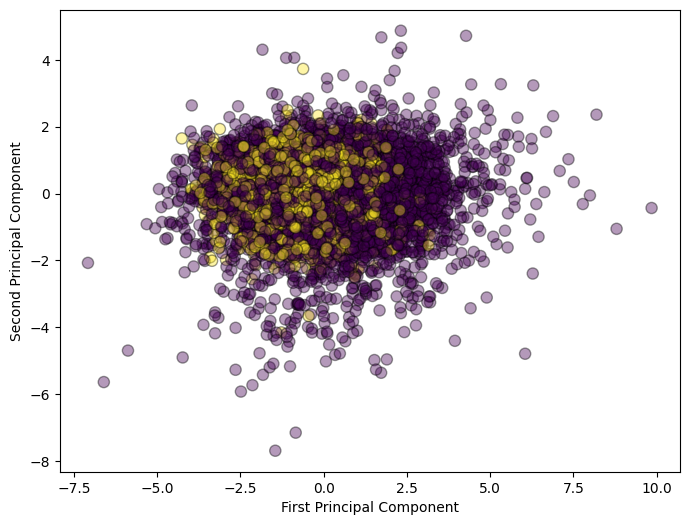

In [37]:
plt.figure(figsize=(8,6))
plt.scatter(
    x_pca[:,0], x_pca[:,1],
    c=full_df_filtered['Healthy_Status'],
    cmap='viridis',
    alpha=0.4,
    edgecolors='black',
    s=65
)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

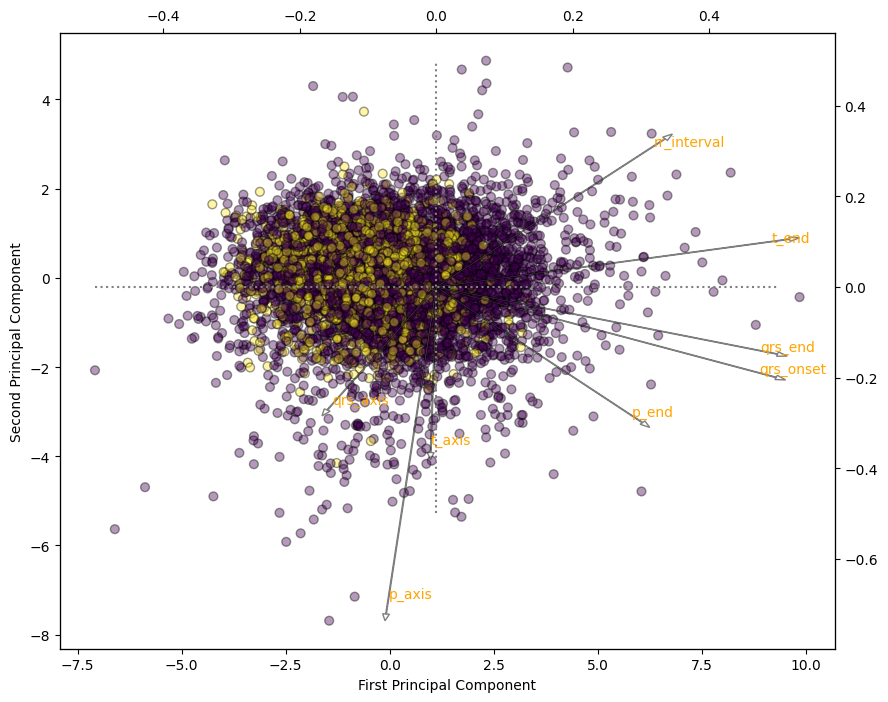

In [38]:
plt.figure(figsize=(10,8))
plt.scatter(
    x_pca[:,0], x_pca[:,1],
    c=full_df_filtered['Healthy_Status'],
    cmap='viridis',
    alpha=0.4,
    edgecolors='black',
    s=40
)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

ax2 = plt.twinx().twiny()
ax2.hlines(0,-0.5,0.5, linestyles='dotted', colors='grey')
ax2.vlines(0,-0.5,0.5, linestyles='dotted', colors='grey')

offset = 0.95
components = pd.DataFrame(pca.components_.T, index=table_data_pca.columns, columns=['PCA1','PCA2'])
for a, i in enumerate(components.index):
    ax2.arrow(0, 0, components['PCA1'][a], -components['PCA2'][a], alpha=0.5, facecolor='white', head_width=.01)
    ax2.annotate(i, (components['PCA1'][a]*offset, -components['PCA2'][a]*offset), color='orange')

Text(0, 0.5, 'Second Principal Component')

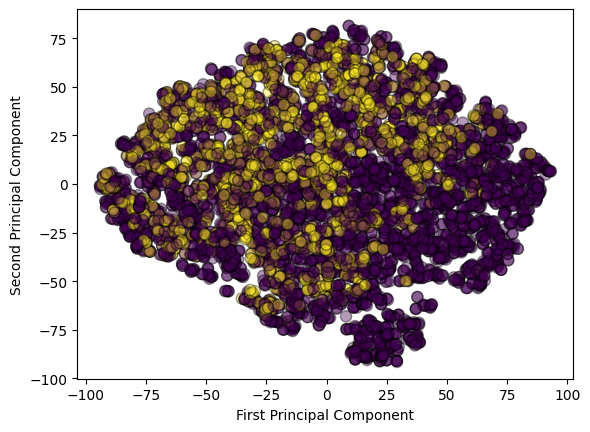

In [40]:
tsne = TSNE(random_state=0, perplexity=20)
scaled_data_tsne = tsne.fit_transform(scaled_data)

plt.scatter(
    scaled_data_tsne[:,0], 
    scaled_data_tsne[:,1], 
    c=full_df_filtered['Healthy_Status'], 
    cmap='viridis', 
    alpha=0.4, 
    edgecolors='black', 
    s=65
)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

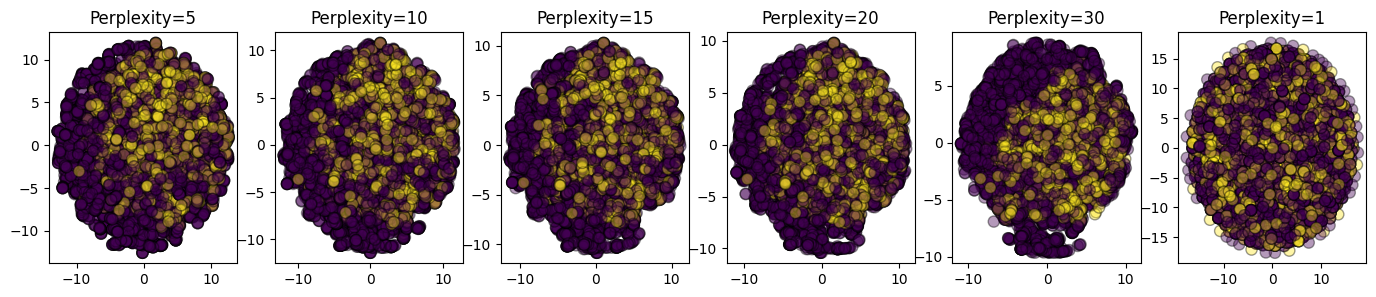

In [42]:
n_components = 2
perplexities = [1, 5, 10, 15, 20, 30]

fig, subplots = plt.subplots(1, len(perplexities), figsize=(17, 3))
for i, perplexity in enumerate(perplexities):
    ax = subplots[i-1]

    tsne = TSNE(n_components=n_components, init='random', random_state=0, perplexity=perplexity, max_iter=300)
    scaled_data_tsne = tsne.fit_transform(scaled_data)

    ax.set_title('Perplexity=%d' % perplexity)
    ax.scatter(
        scaled_data_tsne[:,0], 
        scaled_data_tsne[:,1],
        c=full_df_filtered['Healthy_Status'],
        cmap='viridis',
        alpha=0.4,
        edgecolors='black',
        s=65
    )
    ax.axis('tight')

Как видно, методы PCA и TSNE демонстрируют разделение классов. Анализ графиков показывает, что на начальных значениях perplexity резльутаты примерно одинаковые

In [47]:
# удалим коррелирующие признаки 
table_data = table_data[['rr_interval', 'p_end', 'qrs_onset', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']]


### Примененяем AutoML решения

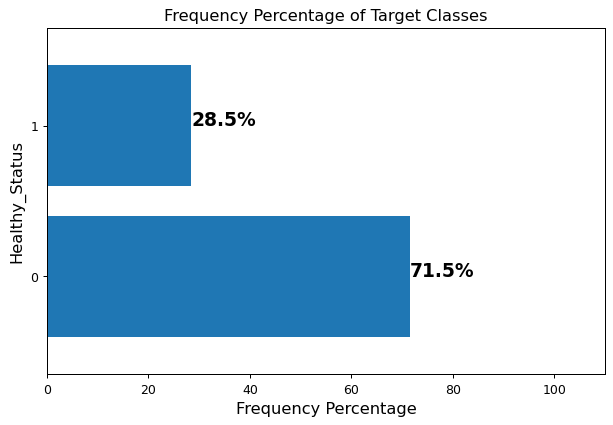

In [50]:
clf_index = 6
plt.figure(figsize=(35,20), dpi=90)
table_data[
    table_data.columns[clf_index]
].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

labels = table_data[
    table_data.columns[clf_index]
].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [51]:
smote = SMOTE(random_state=0)
X_initial = table_data.drop('Healthy_Status', axis=1)
y_initial = table_data['Healthy_Status']

X, y = smote.fit_resample(X_initial, y_initial)
df = pd.DataFrame(X, columns=X_initial.columns)

df['Healthy_Status'] = y
df['Healthy_Status'].value_counts()

Healthy_Status
0    5039
1    5039
Name: count, dtype: int64

In [52]:
X = df.drop(df.columns[[clf_index]], axis=1).iloc[:,:]
y = pd.Series(LabelEncoder().fit_transform(df.iloc[:, clf_index]))

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values,
    test_size=0.3, random_state=0, stratify=y.values
)

In [53]:
# Берем за базовую отметку результаты модели наивного гауссовского байесовского алгоритма
сlassifier = GaussianNB()
сlassifier.fit(X_train, y_train)

y_train__pred = сlassifier.predict(X_train)
y_test__pred = сlassifier.predict(X_test)

In [54]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__pred)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__pred)}'
)

('Accuracy train data 0.7845194216047633',
 'Accuracy test data 0.7913359788359788')

              precision    recall  f1-score   support

        True       0.87      0.69      0.77      1512
       False       0.74      0.90      0.81      1512

    accuracy                           0.79      3024
   macro avg       0.81      0.79      0.79      3024
weighted avg       0.81      0.79      0.79      3024



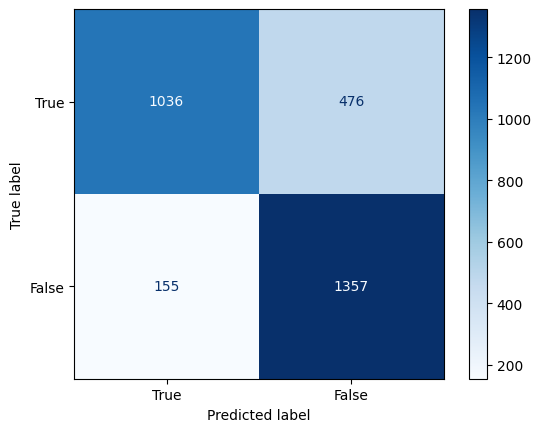

In [55]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__pred, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__pred, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [56]:
autoML_df = df[
    ['rr_interval', 'p_end', 'qrs_onset', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']
]

train_data, test_data = train_test_split(
    autoML_df,
    test_size=0.2, stratify=autoML_df['Healthy_Status'], random_state=42
)
automl = TabularAutoML(
    task=Task('binary'),
    timeout=100,
    memory_limit=2,
    cpu_limit=1,
    reader_params={'n_jobs': 4, 'cv': 3, 'random_state': 42}
)

In [57]:
predictions = automl.fit_predict(train_data, roles={'target': 'Healthy_Status'}, verbose=0)
test_predictions = automl.predict(test_data).data

for i in range(len(test_predictions)):
    if test_predictions[i] > 0.5:
        test_predictions[i] = 1
    else:
        test_predictions[i] = 0

predictions_data = predictions.data
for i in range(len(predictions_data)):
    if predictions_data[i] > 0.5:
        predictions_data[i] = 1
    else:
        predictions_data[i] = 0

2025-05-25 21:22:04,547 - A new study created in memory with name: no-name-1e5ea51c-5b26-4a94-ba9f-ed630788daf3
2025-05-25 21:22:05,853 - Trial 0 finished with value: 0.9361204117063492 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.9361204117063492.
2025-05-25 21:22:08,883 - A new study created in memory with name: no-name-a6b7f08b-3d7e-45b2-9759-786bbe3cc05d
2025-05-25 21:22:09,366 - Trial 0 finished with value: 0.9327367665816327 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.9327367665816327.
2025-05-25 21:22:09,824 - Trial 1 finished with value: 0.9325070197349773 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.5361081166471375e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0

In [58]:
(
    f'Accuracy train data {accuracy_score(train_data["Healthy_Status"], predictions_data)}',
    f'Accuracy test data {accuracy_score(test_data["Healthy_Status"], test_predictions)}'
)

('Accuracy train data 0.84408335400645',
 'Accuracy test data 0.8392857142857143')

              precision    recall  f1-score   support

        True       0.87      0.80      0.83      1008
       False       0.81      0.88      0.85      1008

    accuracy                           0.84      2016
   macro avg       0.84      0.84      0.84      2016
weighted avg       0.84      0.84      0.84      2016



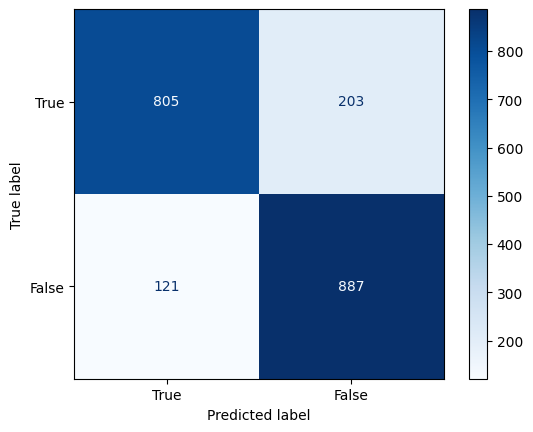

In [59]:
target_names = ['True', 'False']
labels_names = [0, 1]
print(
    classification_report(
        test_data['Healthy_Status'], test_predictions,
        labels=labels_names, target_names=target_names
    )
)

cm = confusion_matrix(test_data['Healthy_Status'], test_predictions, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [60]:
X = df.iloc[:, df.columns != 'Healthy_Status'].values
y = df.iloc[:, df.columns == 'Healthy_Status'].values.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=200)

In [66]:
fedot_model = Fedot(problem='classification', timeout=3)
obtained_pipeline = fedot_model.fit(features=X_train, target=y_train)

2025-05-25 21:26:48,983 - ApiComposer - Initial pipeline was fitted in 1.9 sec.
2025-05-25 21:26:48,984 - ApiComposer - Taking into account n_folds=5, estimated fit time for initial assumption is 9.4 sec.
2025-05-25 21:26:48,985 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2025-05-25 21:26:48,990 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 3 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling', 'xgboost'].
2025-05-25 21:26:49,071 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2025-05-25 21:26:59,884 - MultiprocessingDispatcher - 6 individuals out of 6 in previous population were evaluated successfully.
2025-05-25 21:27:06,979 - MultiprocessingDispatcher - 19 individuals out of 21 in previous population were evaluated successfully.
2025-05-25 21:27:12,685 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2025-05-25 21:27:13,843 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 1/10000 [00:24<68:39:04, 24.72s/gen]

2025-05-25 21:27:15,576 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2025-05-25 21:27:18,812 - MultiprocessingDispatcher - 10 individuals out of 10 in previous population were evaluated successfully.


Generations:   0%|          | 2/10000 [00:29<36:23:02, 13.10s/gen]

2025-05-25 21:27:36,111 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2025-05-25 21:27:40,524 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.


Generations:   0%|          | 3/10000 [00:51<47:18:11, 17.03s/gen]

2025-05-25 21:27:52,792 - MultiprocessingDispatcher - 32 individuals out of 32 in previous population were evaluated successfully.
2025-05-25 21:27:57,857 - MultiprocessingDispatcher - 23 individuals out of 23 in previous population were evaluated successfully.
2025-05-25 21:27:57,874 - MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.


Generations:   0%|          | 4/10000 [01:08<47:38:17, 17.16s/gen]

2025-05-25 21:28:10,418 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-05-25 21:28:17,228 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 5/10000 [01:28<49:50:06, 17.95s/gen]

2025-05-25 21:28:19,129 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-05-25 21:28:21,999 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.


Generations:   0%|          | 6/10000 [01:32<37:23:27, 13.47s/gen]

2025-05-25 21:28:33,597 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2025-05-25 21:28:34,273 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.


Generations:   0%|          | 7/10000 [01:45<36:18:06, 13.08s/gen]

2025-05-25 21:28:34,281 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 7/10000 [01:45<41:41:51, 15.02s/gen]

2025-05-25 21:28:34,346 - ApiComposer - Hyperparameters tuning started with 1 min. timeout


2025-05-25 21:28:39,822 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 1} 
Initial metric: [0.919]
  0%|          | 11/100000 [01:09<174:59:21,  6.30s/trial, best loss: -0.9173210209621658]
2025-05-25 21:29:53,548 - SimultaneousTuner - Final graph: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 1}
2025-05-25 21:29:53,550 - SimultaneousTuner - Final metric: 0.919
2025-05-25 21:29:53,552 - ApiComposer - Hyperparameters tuning finished
2025-05-25 21:29:54,224 - ApiComposer - Model generation finished
2025-05-25 21:29:55,411 - FEDOT logger - Final pipeline was fitted
2025-05-25 21:29:55,413 - FEDOT logger - Final pipeline: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 10}


In [67]:
y_train__predict = fedot_model.predict(X_train)
y_test__predict = fedot_model.predict(X_test)

In [68]:
(
    f'Accuracy train data {accuracy_score(y_train, y_train__predict)}',
    f'Accuracy test data {accuracy_score(y_test, y_test__predict)}'
)

('Accuracy train data 1.0', 'Accuracy test data 0.8379629629629629')

              precision    recall  f1-score   support

        True       0.92      0.74      0.82      1511
       False       0.78      0.93      0.85      1513

    accuracy                           0.84      3024
   macro avg       0.85      0.84      0.84      3024
weighted avg       0.85      0.84      0.84      3024



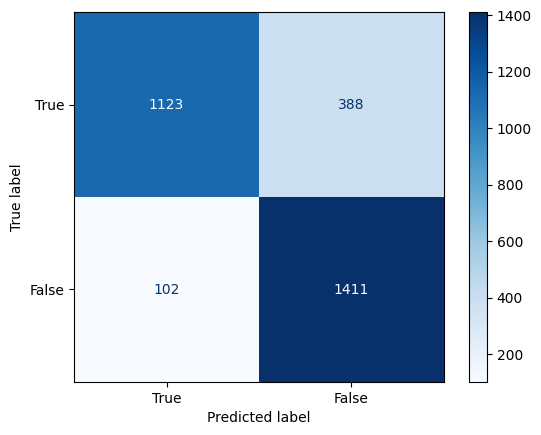

In [69]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_test__predict, labels=labels_names, target_names=target_names))

cm = confusion_matrix(y_test, y_test__predict, labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format='g')
plt.show()

In [70]:
fedot_model.current_pipeline

{'depth': 1, 'length': 1, 'nodes': [rf]}

### Отображаем результаты в MLFlow

In [72]:
mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')
mlflow.set_experiment('Task 2')

2025/05/25 21:41:14 INFO mlflow.tracking.fluent: Experiment with name 'Task 2' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/311225456815090235', creation_time=1748209274895, experiment_id='311225456815090235', last_update_time=1748209274895, lifecycle_stage='active', name='Task 2', tags={}>

In [79]:
joblib.dump(automl, 'lama_model.pkl')

with open('lama_model.pkl', 'wb') as f:
    pickle.dump(automl, f)

with mlflow.start_run(run_name='LAMA'):    
    mlflow.log_params(
        {
            'n_jobs': 4, 
            'cv': 3, 
            'random_state': 42
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(train_data["Healthy_Status"], predictions_data),
            'Accuracy test data': accuracy_score(test_data["Healthy_Status"], test_predictions)
        }
    )
    mlflow.log_artifact('lama_model.pkl')

    mlflow.sklearn.log_model(
        sk_model=automl,
        artifact_path='lama_model',
        signature=infer_signature(train_data, predictions_data),
        input_example=train_data
    )

🏃 View run LAMA at: http://127.0.0.1:8080/#/experiments/311225456815090235/runs/04907de077714a4cb474a9109caa6d68
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/311225456815090235


In [78]:
joblib.dump(fedot_model, 'fedot_model.pkl')

with open('fedot_model.pkl', 'wb') as f:
    pickle.dump(fedot_model, f)

with mlflow.start_run(run_name='FEDOT'):
    y_train__predict = fedot_model.predict(X_train)
    y_test__predict = fedot_model.predict(X_test)
    
    mlflow.log_params(
        {
            'problem':'classification',
            'timeout': 3
        }
    )
    mlflow.log_metrics(
        {
            'Accuracy train data': accuracy_score(y_train, y_train__predict),
            'Accuracy test data': accuracy_score(y_test, y_test__predict)
        }
    )
    mlflow.log_artifact('fedot_model.pkl')
    
    mlflow.sklearn.log_model(
        sk_model=fedot_model,
        artifact_path='model_fedot',
        signature=infer_signature(X_train, y_train__predict),
        input_example=X_train
    )

🏃 View run FEDOT at: http://127.0.0.1:8080/#/experiments/311225456815090235/runs/4848844a9b4a406a9fa4040bcdb97605
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/311225456815090235
